In [1]:
#############
## PRELUDE ##
#############
# Setup python imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setup sqlite3 connection
import sqlite3
con = sqlite3.connect("file:../data_exp.db?immutable=1")

# Setup sqlite3 user functions
from utils.sql import sql_regexp, DistributionSummary, Last
con.create_function("regexp", 2, sql_regexp)
con.create_aggregate("dist_summary", 3, DistributionSummary)
con.create_aggregate("last", 1, Last)

## Price Adjustments

In [2]:
adjustment_all = pd.read_sql_query(f"""
SELECT
    rowid,
    cast(line_srvc_cnt as int) as count,
    (1 - (cast(average_Medicare_allowed_amt as real) / average_submitted_chrg_amt)) * 100 as adjustment
FROM PUP_data
""", con)
assert(len(adjustment_all["adjustment"].dropna()) == len(adjustment_all["adjustment"]))
adjustment_all.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9847443 entries, 0 to 9847442
Columns: 3 entries, rowid to adjustment
dtypes: float64(1), int64(2)
memory usage: 225.4 MB


In [41]:
adjustments_less_than_20pp = adjustment_all[adjustment_all["adjustment"] < 20]["count"].sum()
pp_adjustments_less_than_20pp = adjustments_less_than_20pp / adjustment_all_total_count * 100
print(f"{pp_adjustments_less_than_20pp:.2f}% of claims are adjusted less than 20pp")
adjustments_more_than_80pp = adjustment_all[adjustment_all["adjustment"] > 80]["count"].sum()
pp_adjustments_more_than_80pp = adjustments_more_than_80pp / adjustment_all_total_count * 100
print(f"{pp_adjustments_more_than_80pp:.2f}% of claims are adjusted more than 80pp (ie. >5x discount)")

11.51% of claims are adjusted less than 20pp
19.05% of claims are adjusted more than 80pp (ie. >5x discount)


### Histogram Visualization

Text(0.5, 0, '% discount from original bill*')

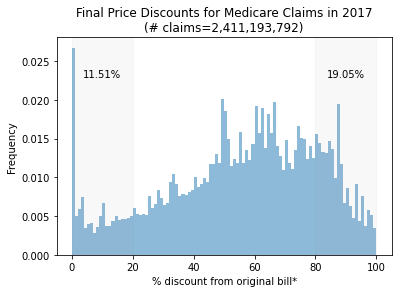

In [47]:
adjustment_all_total_count = adjustment_all["count"].sum()
adjustment_all["adjustment"].plot.hist(
    bins=100,
    density=True,
    alpha=0.5,
    weights=adjustment_all["count"],
    title=f"Final Price Discounts for Medicare Claims in 2017\n(# claims={adjustment_all_total_count:,d})"
)
plt.axvspan(0, 20, color='gray', alpha=0.05)
plt.text(10, 0.023, f"{pp_adjustments_less_than_20pp:.2f}%", ha="center")
plt.axvspan(80, 100, color='gray', alpha=0.05)
plt.text(90, 0.023, f"{pp_adjustments_more_than_80pp:.2f}%", ha="center")
plt.xlabel("% discount from original bill*")

### Procedures w/ the largest adjustments

The following is a list of all procedures...

- ...with over 1000 claims filed
- ...sorted by size of the adjustment (descending)

In [68]:
pd.read_sql_query(f"""
SELECT *
FROM (
    SELECT
        sum(line_srvc_cnt) as count,
        hcpcs_code,
        (1 - (sum(cast(average_Medicare_allowed_amt as real)) / sum(average_submitted_chrg_amt))) * 100 as adjustment,
        avg(average_Medicare_allowed_amt),
        avg(average_submitted_chrg_amt)
    FROM PUP_data
    WHERE hcpcs_code GLOB '[0-9]*'
    GROUP BY hcpcs_code
    ORDER BY adjustment DESC
)
WHERE count > 1000
""", con)

,count,hcpcs_code,adjustment,avg(average_Medicare_allowed_amt),avg(average_submitted_chrg_amt)
0,16008.0,31623,96.929778,20.017055,651.974146
1,2063.0,43261,96.582958,41.099173,1202.770650
2,15781.0,93313,96.484897,11.892190,338.316953
3,1735.0,87168,95.019607,5.822684,116.912141
4,9948.0,82139,94.984407,22.901774,456.611499
...,...,...,...,...,...
2735,1323.0,81540,6.681652,2920.300000,3129.395314
2736,3291.0,81407,2.468542,773.581740,793.161258
2737,3158.0,81202,2.337351,106.999050,109.559848
2738,33752.0,0379T,0.828738,74.378447,75.000000


### Appendix

Text(0.5, 0, '% discount from original bill*')

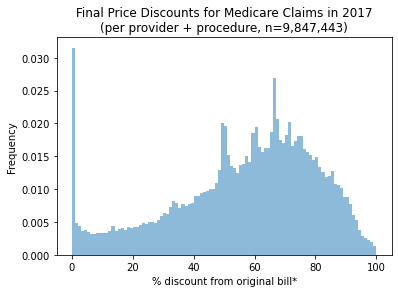

In [32]:
adjustment_all_num = len(adjustment_all["adjustment"])
adjustment_all["adjustment"].plot.hist(
    bins=100,
    density=True,
    alpha=0.5,
    title=f"Final Price Discounts for Medicare Claims in 2017\n(per provider + procedure, n={len(adjustment_all):,d})"
)
plt.xlabel("% discount from original bill*")

In [5]:
pd.read_sql_query(f"""
SELECT
    rowid,
    cast(line_srvc_cnt as int) as count,
    npi,
    hcpcs_code,
    (1 - (cast(average_Medicare_allowed_amt as real) / average_submitted_chrg_amt)) * 100 as adjustment,
    average_Medicare_allowed_amt,
    average_submitted_chrg_amt
FROM PUP_data
WHERE adjustment > 99
ORDER BY adjustment DESC
""", con)

,rowid,count,npi,hcpcs_code,adjustment,average_Medicare_allowed_amt,average_submitted_chrg_amt
0,361992,18,1033317219,J2001,99.996970,0.02,660
1,4808426,86,1487827408,J2001,99.996140,0.0193023256,500
2,9596408,513,1972588598,J1071,99.992580,0.0222612086,300
3,8403401,40,1851368377,J3490,99.990015,0.16925,1695
4,4788975,16,1487716437,31623,99.989092,0.0925,848
...,...,...,...,...,...,...,...
12712,1595350,16,1164458725,93325,99.000338,3.7,370.125
12713,3375808,18723,1346239894,J9267,99.000313,0.149952999,15
12714,1555502,3743,1154644383,Q9967,99.000274,0.1245658563,12.46
12715,824759,95,1083669196,20610,99.000083,25.357894737,2536
